<a href="https://colab.research.google.com/github/rafaelcostadefarias/100-days-of-code/blob/master/LSTM_Test_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 5.5MB 6.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=e43fe15a56ec5351feb36707a162d7df47a07c1fa04697ce41bffc5d5cafeb12
  Stored in directory: /tmp/pip-ephem-wheel-cache-22ydahf2/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import yfinance as yf
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [5]:
yf.pdr_override()

In [53]:
company = 'AAPL'

In [54]:
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

In [55]:
data = web.get_data_yahoo(company, start=start, end=end)

In [56]:
#Preparando os dados
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

In [57]:
for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

In [58]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [59]:
#Modelo
model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) #prox fechamento

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25,batch_size=32)

Epoch 1/25
61/61 [==============================] - 7s 62ms/step - loss: 0.0266
Epoch 2/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0020
Epoch 3/25
61/61 [==============================] - 4s 66ms/step - loss: 0.0021
Epoch 4/25
61/61 [==============================] - 4s 65ms/step - loss: 0.0021
Epoch 5/25
61/61 [==============================] - 4s 65ms/step - loss: 0.0019
Epoch 6/25
61/61 [==============================] - 4s 66ms/step - loss: 0.0015
Epoch 7/25
61/61 [==============================] - 4s 66ms/step - loss: 0.0015
Epoch 8/25
61/61 [==============================] - 4s 65ms/step - loss: 0.0016
Epoch 9/25
61/61 [==============================] - 4s 65ms/step - loss: 0.0015
Epoch 10/25
61/61 [==============================] - 4s 66ms/step - loss: 0.0013
Epoch 11/25
61/61 [==============================] - 4s 67ms/step - loss: 0.0013
Epoch 12/25
61/61 [==============================] - 4s 66ms/step - loss: 0.0012
Epoch 13/25
61/61 [==================

In [60]:
##########Backtest

#Carregar dados
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime(2020,12,31)
test_data = web.get_data_yahoo(company, start=start, end=end)

In [61]:
actual_prices = test_data['Adj Close'].values

total_dataset = pd.concat((data['Adj Close'], test_data['Adj Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [62]:
#Chute nos dados de teste
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days: x,0])

In [63]:
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))

In [64]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

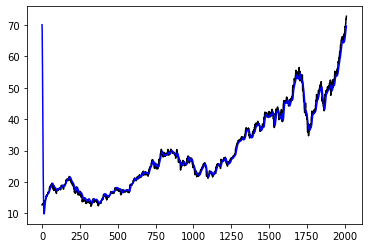

In [65]:
#Plot nos chutes
plt.plot(actual_prices, color='black')
plt.plot(predicted_prices, color='blue')

plt.show()

In [66]:
#Chute no amanha

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

In [67]:
#print(scaler.inverse_transform(real_data[-1]))

In [68]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

In [69]:
prediction

array([[70.06297]], dtype=float32)